# Visualising neural networks

## Labelled data sets whose distinct parts are intertangled.

Firstly we define a function that produces $N$ random samples from a probability distribution that is concentrated around the ring
$$
\{ (x,y,0) \in \mathbb{R}^3: x^2 + y^2 = R^2\}
$$

The sampled points will have a distance from the ring that is normally distributed with standard deviation $r$. 

In [1]:
import numpy as np

#we define N random points
def rpg(R, r, N):
    #two random angles are chosen
    theta1 = 2*np.pi*np.random.rand(N)
    theta2 = np.pi*np.random.rand(N)
    #the small radius is chosen from a normal distribution
    #negative r is allowed, hence theta2 is chosen only from 0 to pi.
    sr = r*np.random.randn(N)
    #comment out the line above, switch with the line below if you want to 
    #sr = r*np.ones(N)
    #define a rotator matrix for each theta in the array theta2
    Roty = rotator(theta2, axis='y')
    #now create a set of points of the form (r, 0, 0)^t
    prerot = np.zeros((3,N))
    prerot[0,:] = sr
    #and rotate them according to the corresponding theta2 angles
    addpoints = np.zeros((3,N))
    for i in np.arange(N):
        addpoints[:,i] = (Roty[:,:,i]).dot(prerot[:,i])
    #Now add these points to (R,0,0)^t, 
    #then rotate them according to angles in theta1 around  axis
    Rotz = rotator(theta1, axis = 'z')
    prerot2 = np.zeros((3,N))
    prerot2[0] = R*np.ones(N)
    prerot2 += addpoints
    points = np.zeros((3,N))
    for i in np.arange(N):
        points[:,i] = Rotz[:,:,i].dot(prerot2[:,i]) 
    return points

#Returns a tensor of rotation matrices 
#where R[:,:,i] is the rotation matrix of thetas[i]
#axis determines around which axis
def rotator(thetas, axis='z'):
    c, s = np.cos(thetas), np.sin(thetas)
    N = len(thetas)
    ones = np.ones(N)
    zeros = np.zeros(N)
    if axis == 'x':
        R = np.array(((ones,zeros,zeros),(zeros,c,-s),(zeros,s,c)))
    if axis == 'y':
        R = np.array(((c,zeros,-s),(zeros,ones,zeros),(s,zeros, c)))
    if axis == 'z':
        R = np.array(((c,-s,zeros),(s,c,zeros),(zeros,zeros,ones)))
    return R


# I realized I could do another implementation, where I first pick from 
# a 3d gaussian sampling and later rotate that with a random angle.

def rpg2(R,r,N):
    points = r*np.random.multivariate_normal(mean = [R,0,0], cov = np.identity(3), size = N)
    thetas = 2*np.pi*np.random.rand(N)
    Rots = np.array(list(map(rot2, thetas)))
    for i in np.arange(N):
        points[i] = points[i].dot(Rots[i])
    return points

def rot2(theta):
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s,0),(s,c,0),(0,0,1)))
    return R

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

xs, ys, zs = rpg(14,1,3000)
#xs,ys,zs = rpg2(14,1,3000).transpose()
#cxs, cys, czs = np.cos(np.arange(1000)*np.pi/500),np.sin(np.arange(1000)*np.pi/500), np.zeros(1000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, s = 0.1,marker='o')
                       
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ln = fig.add_subplot(111, projection='3d')
#ln.plot(cxs,cys,czs)

plt.show()

<Figure size 640x480 with 1 Axes>

Let us now define the other donut, and plot them on the same graph, one red one blue.

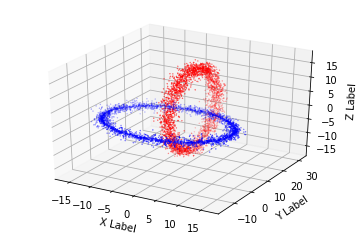

In [3]:
R = rot2(np.pi/2)
P = np.array(((1,0,0),(0,0,1),(0,1,0)))
R = (P.dot(R)).dot(P)
redpoints = rpg2(14,1,3000)

redpoints = np.array(list(map(lambda x: R.dot(x) + np.array([0,14,0]),redpoints)))

rxs,rys, rzs = redpoints.transpose()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rxs, rys, rzs, s = 0.1, c = 'red', marker='o')
ax.scatter(xs,ys,zs, s = 0.1, c = 'blue', marker = 'o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ln = fig.add_subplot(111, projection='3d')
#ln.plot(cxs,cys,czs)

plt.show()

In [63]:
import torch
import torch.tensor as tt
import torch.nn as nn
import torch.nn.functional as F

# This creates a set of points and labels, 
# with N1 blue points labeled 1
# and N2 red points labeled 0
def dataCreator(R, r, N1, N2):
    BluePoints = rpg(R,r,N1).transpose()
    RedPoints = rpg2(R,r,N2)
    Rot = rot2(np.pi/2)
    P = np.array(((1,0,0),(0,0,1),(0,1,0)))
    Rot = (P.dot(Rot)).dot(P)
    RedPoints = np.array(list(map(lambda x: Rot.dot(x) + np.array([0,R,0]),RedPoints)))
    X = torch.cat((tt(BluePoints), tt(RedPoints)),0)
    Y = torch.cat((tt([1,0], dtype=torch.float).repeat(N1,1), tt([0,1], dtype=torch.float).repeat(N2,1)),0)
    return X,Y

In [64]:
BluePoints = x_test[list(map(lambda a: list(a)==[1,0], y_test))]
BluePoints.transpose(0,1)

tensor([[ 6.9889e+00,  6.8013e+00,  2.8029e+00, -4.9018e+00,  1.6986e+00,
         -3.1302e-01,  5.4762e+00,  8.5267e+00, -9.9760e+00,  5.9516e+00,
          3.1685e-01, -9.4491e+00,  8.4596e+00, -7.0724e+00, -9.3137e+00,
         -8.6068e+00, -1.3026e+00,  9.1177e-01,  3.6857e+00, -7.8725e+00,
         -7.1440e+00,  9.5366e+00, -8.9206e+00, -8.9576e+00,  1.0397e+01,
          9.8262e+00,  8.1828e+00, -9.6878e+00, -9.0468e+00, -2.9252e+00,
          6.0430e+00, -3.6722e+00, -7.9069e+00,  9.7324e+00, -4.0875e+00,
          5.4126e+00, -9.1231e+00, -2.6344e+00,  1.1061e+01,  9.2160e+00,
         -2.8253e+00,  4.3467e+00,  1.0888e+01, -3.3584e+00,  2.6886e-01,
         -6.3715e+00,  9.8500e+00, -7.7163e+00, -7.3527e+00, -1.8390e+00,
         -9.2101e+00, -2.3024e+00,  3.6655e+00,  3.6345e+00, -1.0827e+01,
         -1.0928e+00, -1.0299e+01, -9.5664e+00, -9.2241e+00, -1.1037e+01,
          4.3638e+00, -1.0112e+01, -1.5705e+00, -9.5220e+00,  9.7614e+00,
         -9.5445e+00,  9.4763e+00, -6.

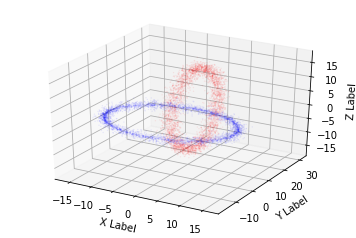

In [142]:
x_train, y_train = dataCreator(14,1,4000,4000)
x_test, y_test = dataCreator(14,1,400,400)

def dataVisualizer(xs, ys):
    BluePoints = xs[list(map(lambda a: list(a)==[1,0], ys))]
    RedPoints = xs[list(map(lambda a: list(a)==[0,1], ys))]
    bxs, bys, bzs = BluePoints.transpose(0,1)
    rxs, rys, rzs = RedPoints.transpose(0,1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rxs, rys, rzs, s = 0.1, c = 'red', marker='o', alpha = 0.1)
    ax.scatter(bxs, bys, bzs, s = 0.1, c = 'blue', marker = 'o', alpha = 0.1)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    
dataVisualizer(x_train, y_train)

Now we train this data.

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [196]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
        self.fc6 = nn.Linear(3, 3)
        self.fc7 = nn.Linear(3, 3)
        self.fc8 = nn.Linear(3, 3)
        self.fc9 = nn.Linear(3, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return F.softmax(x)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=3, bias=True)
  (fc5): Linear(in_features=3, out_features=3, bias=True)
  (fc6): Linear(in_features=3, out_features=3, bias=True)
  (fc7): Linear(in_features=3, out_features=3, bias=True)
  (fc8): Linear(in_features=3, out_features=3, bias=True)
  (fc9): Linear(in_features=3, out_features=2, bias=True)
)


In [197]:
import torch.optim as optim
learning_rate = 0.001
# create a stochastic gradient descent optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# create a loss function
# maybe I try also the following. Are they really different?
#criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

In [198]:
x_train = x_train.float()
y_train = y_train.float()
x_test = x_test.float()
y_test = y_test.float()

trainset = list(zip(x_train, y_train))
testset = list(zip(x_test, y_test))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)


In [199]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

/home/ekiral/miniconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  1000] loss: 0.249
[1,  2000] loss: 0.240
[2,  1000] loss: 0.199
[2,  2000] loss: 0.172
[3,  1000] loss: 0.125
[3,  2000] loss: 0.080
[4,  1000] loss: 0.050
[4,  2000] loss: 0.043
[5,  1000] loss: 0.040
[5,  2000] loss: 0.038
[6,  1000] loss: 0.039
[6,  2000] loss: 0.033
[7,  1000] loss: 0.035
[7,  2000] loss: 0.031
[8,  1000] loss: 0.030
[8,  2000] loss: 0.033
[9,  1000] loss: 0.034
[9,  2000] loss: 0.028
[10,  1000] loss: 0.031
[10,  2000] loss: 0.028
[11,  1000] loss: 0.031
[11,  2000] loss: 0.026
[12,  1000] loss: 0.029
[12,  2000] loss: 0.027
[13,  1000] loss: 0.029
[13,  2000] loss: 0.026
[14,  1000] loss: 0.027
[14,  2000] loss: 0.028
[15,  1000] loss: 0.025
[15,  2000] loss: 0.027
[16,  1000] loss: 0.027
[16,  2000] loss: 0.024
[17,  1000] loss: 0.024
[17,  2000] loss: 0.027
[18,  1000] loss: 0.026
[18,  2000] loss: 0.026
[19,  1000] loss: 0.029
[19,  2000] loss: 0.021
[20,  1000] loss: 0.024
[20,  2000] loss: 0.026
Finished Training


In [200]:
net(x_test)

/home/ekiral/miniconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[9.8469e-01, 1.5315e-02],
        [9.8563e-01, 1.4367e-02],
        [9.8478e-01, 1.5217e-02],
        ...,
        [1.0265e-06, 1.0000e+00],
        [1.1782e-02, 9.8822e-01],
        [8.5352e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward>)

So indeed the first $N_1$ elements are all should output $[1,0]$ and the last $N_2$ outputs should be all $[0,1]$. This seems rather close at this first glance. 

In [201]:
def percentIncorrect(net, x_test, y_test):
    guesses = list(map(lambda a: net(a).argmax().item(), x_test))
    results = list(map(lambda a: a.argmax().item(), y_test))
    return ((np.array(guesses)  - np.array(results))**2).mean()
    
percentIncorrect(net,x_test,y_test)

/home/ekiral/miniconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.02375

This is less than the COVID-19 death rate. I'll take that as satisfactory. There are a few errors here and there. By the way the function could not for the life of it learn to separate the data without the softmax at the end. This is just strange. I don't understand why. Also softmax together with MSELoss just feels wrong. In any case these are points to ponder.

Now the next goal is to take this trained network and see what happens at middle layers. And see them 

In [207]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
        self.fc6 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
        self.fc6 = nn.Linear(3, 3)
        self.fc7 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    

class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
        self.fc6 = nn.Linear(3, 3)
        self.fc7 = nn.Linear(3, 3)
        self.fc8 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x
    
    
class Net9(nn.Module):
    def __init__(self):
        super(Net9, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 3)
        self.fc6 = nn.Linear(3, 3)
        self.fc7 = nn.Linear(3, 3)
        self.fc8 = nn.Linear(3, 3)
        self.fc9 = nn.Linear(3, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return x

    
net1 = Net1()
net1.fc1.bias = net.fc1.bias
net1.fc1.weight = net.fc1.weight


net2 = Net2()
net2.fc1.bias = net.fc1.bias
net2.fc1.weight = net.fc1.weight
net2.fc2.bias = net.fc2.bias
net2.fc2.weight = net.fc2.weight

net3 = Net3()
net3.fc1.bias = net.fc1.bias
net3.fc1.weight = net.fc1.weight
net3.fc2.bias = net.fc2.bias
net3.fc2.weight = net.fc2.weight
net3.fc3.bias = net.fc3.bias
net3.fc3.weight = net.fc3.weight

net4 = Net4()
net4.fc1.bias = net.fc1.bias
net4.fc1.weight = net.fc1.weight
net4.fc2.bias = net.fc2.bias
net4.fc2.weight = net.fc2.weight
net4.fc3.bias = net.fc3.bias
net4.fc3.weight = net.fc3.weight
net4.fc4.bias = net.fc4.bias
net4.fc4.weight = net.fc4.weight

net5 = Net5()
net5.fc1.bias = net.fc1.bias
net5.fc1.weight = net.fc1.weight
net5.fc2.bias = net.fc2.bias
net5.fc2.weight = net.fc2.weight
net5.fc3.bias = net.fc3.bias
net5.fc3.weight = net.fc3.weight
net5.fc4.bias = net.fc4.bias
net5.fc4.weight = net.fc4.weight
net5.fc5.bias = net.fc5.bias
net5.fc5.weight = net.fc5.weight


net6 = Net6()
net6.fc1.bias = net.fc1.bias
net6.fc1.weight = net.fc1.weight
net6.fc2.bias = net.fc2.bias
net6.fc2.weight = net.fc2.weight
net6.fc3.bias = net.fc3.bias
net6.fc3.weight = net.fc3.weight
net6.fc4.bias = net.fc4.bias
net6.fc4.weight = net.fc4.weight
net6.fc5.bias = net.fc5.bias
net6.fc5.weight = net.fc5.weight
net6.fc6.bias = net.fc6.bias
net6.fc6.weight = net.fc6.weight


net7 = Net7()
net7.fc1.bias = net.fc1.bias
net7.fc1.weight = net.fc1.weight
net7.fc2.bias = net.fc2.bias
net7.fc2.weight = net.fc2.weight
net7.fc3.bias = net.fc3.bias
net7.fc3.weight = net.fc3.weight
net7.fc4.bias = net.fc4.bias
net7.fc4.weight = net.fc4.weight
net7.fc5.bias = net.fc5.bias
net7.fc5.weight = net.fc5.weight
net7.fc6.bias = net.fc6.bias
net7.fc6.weight = net.fc6.weight
net7.fc7.bias = net.fc7.bias
net7.fc7.weight = net.fc7.weight


net8 = Net8()
net8.fc1.bias = net.fc1.bias
net8.fc1.weight = net.fc1.weight
net8.fc2.bias = net.fc2.bias
net8.fc2.weight = net.fc2.weight
net8.fc3.bias = net.fc3.bias
net8.fc3.weight = net.fc3.weight
net8.fc4.bias = net.fc4.bias
net8.fc4.weight = net.fc4.weight
net8.fc5.bias = net.fc5.bias
net8.fc5.weight = net.fc5.weight
net8.fc6.bias = net.fc6.bias
net8.fc6.weight = net.fc6.weight
net8.fc7.bias = net.fc7.bias
net8.fc7.weight = net.fc7.weight
net8.fc8.bias = net.fc8.bias
net8.fc8.weight = net.fc8.weight

net9 = Net9()
net9.fc1.bias = net.fc1.bias
net9.fc1.weight = net.fc1.weight
net9.fc2.bias = net.fc2.bias
net9.fc2.weight = net.fc2.weight
net9.fc3.bias = net.fc3.bias
net9.fc3.weight = net.fc3.weight
net9.fc4.bias = net.fc4.bias
net9.fc4.weight = net.fc4.weight
net9.fc5.bias = net.fc5.bias
net9.fc5.weight = net.fc5.weight
net9.fc6.bias = net.fc6.bias
net9.fc6.weight = net.fc6.weight
net9.fc7.bias = net.fc7.bias
net9.fc7.weight = net.fc7.weight
net9.fc8.bias = net.fc8.bias
net9.fc8.weight = net.fc8.weight
net9.fc9.bias = net.fc9.bias
net9.fc9.weight = net.fc9.weight



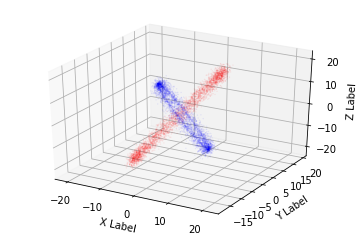

In [210]:
#Let us transform points according to the partial slices and visualize them
transformedpoints1 = net1(x_train).detach()
dataVisualizer(transformedpoints1, y_train)

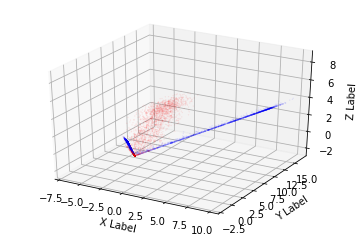

In [211]:
#Let us transform points according to the partial slices and visualize them
transformedpoints2 = net2(x_train).detach()
dataVisualizer(transformedpoints2, y_train)

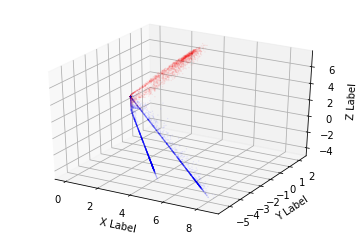

In [212]:
#Let us transform points according to the partial slices and visualize them
transformedpoints3 = net3(x_train).detach()
dataVisualizer(transformedpoints3, y_train)

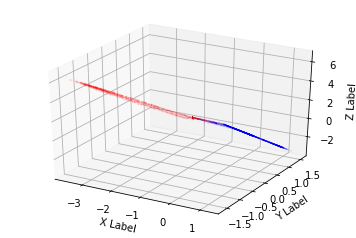

In [213]:
#Let us transform points according to the partial slices and visualize them
transformedpoints4 = net4(x_train).detach()
dataVisualizer(transformedpoints4, y_train)

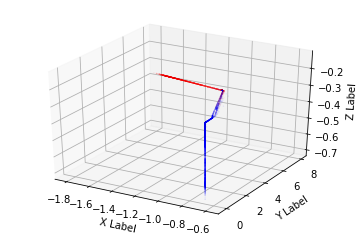

In [214]:
#Let us transform points according to the partial slices and visualize them
transformedpoints5 = net5(x_train).detach()
dataVisualizer(transformedpoints5, y_train)

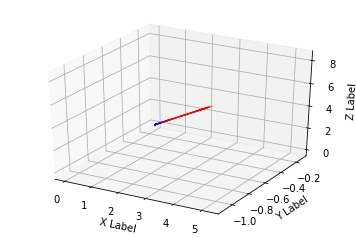

In [215]:
#Let us transform points according to the partial slices and visualize them
transformedpoints6 = net6(x_train).detach()
dataVisualizer(transformedpoints6, y_train)

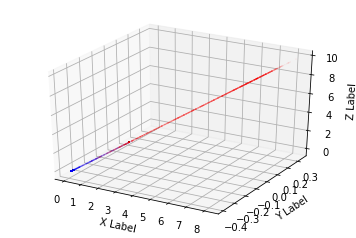

In [216]:
#Let us transform points according to the partial slices and visualize them
transformedpoints7 = net7(x_train).detach()
dataVisualizer(transformedpoints7, y_train)

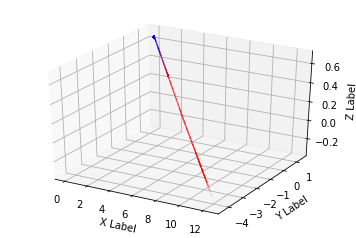

In [217]:
#Let us transform points according to the partial slices and visualize them
transformedpoints8 = net8(x_train).detach()
dataVisualizer(transformedpoints8, y_train)

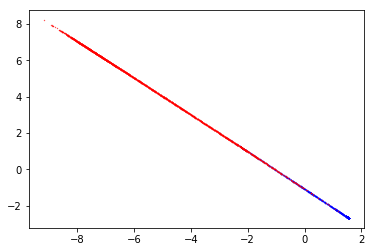

In [218]:
#Let us transform points according to the partial slices and visualize them
transformedpoints9 = net9(x_train).detach()
bxs, bys = transformedpoints9[list(map(lambda a: list(a)==[1,0], y_train))].transpose(0,1)
rxs, rys = transformedpoints9[list(map(lambda a: list(a)==[0,1], y_train))].transpose(0,1)



plt.scatter(bxs, bys, c = 'blue', s = 0.1)
plt.scatter(rxs, rys, c = 'red', s = 0.1)
plt.show()